In [ ]:
%%shell
pip install python-mnist

In [ ]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Subset
from torchsummary import summary

import numpy as np
import os
import random
import copy
import time
import sys
import pandas as pd
from matplotlib import pyplot as plt

from mnist import MNIST

In [ ]:
# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.3.1
0.4.2


# Preprocessing Step

### Using GPU

In [ ]:
!nvidia-smi

Thu Jan 16 17:41:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    37W / 250W |    821MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print('You are re running on: ', device)

You are re running on:  cuda


### Load and Process Data

In [ ]:
# Download and unzip the dataset.
os.system("curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o /tmp/train-images-idx3-ubyte.gz")
os.system("curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o /tmp/train-labels-idx1-ubyte.gz")
os.system("curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o /tmp/t10k-images-idx3-ubyte.gz")
os.system("curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o /tmp/t10k-labels-idx1-ubyte.gz")

# unzip the files
os.system("gunzip /tmp/*.gz")

512

In [ ]:
# Call Data
mnistdata = MNIST("/tmp")
data_set = mnistdata.load_training()
vanillax_list, vanillay_list = mnistdata.load_training()
testx_list, testy_list = mnistdata.load_testing()

In [ ]:
# Split into Train and Validation
trainx_list = np.array(vanillax_list[:50000],dtype = "float32").reshape(50000, 28, 28)
trainy_list = np.array(vanillay_list[:50000],dtype = "float32")
validx_list = np.array(vanillax_list[50000:],dtype = "float32").reshape(10000, 28, 28)
validy_list = np.array(vanillay_list[50000:],dtype = "float32")

# Load Train, Validation, Test to Torch
trainx = torch.from_numpy(trainx_list).float()
trainy = torch.from_numpy(trainy_list).int()
validx = torch.from_numpy(validx_list).float()
validy = torch.from_numpy(validy_list).int()

testx_list = np.array(testx_list,dtype = "float32").reshape(10000, 28, 28)
testy_list = np.array(testy_list,dtype = "float32")
testx = torch.from_numpy(testx_list).float()
testy = torch.from_numpy(testy_list).int()

# Add Extra Channel
trainx = trainx.unsqueeze(1).float()
validx = validx.unsqueeze(1).float()
testx = testx.unsqueeze(1).float()

print(trainx.type(), validx.type(),testx.type())

torch.FloatTensor torch.FloatTensor torch.FloatTensor


In [ ]:
# Function for filtering Fashion MINST-1
def filter_dataset(xs, ys, labels):
  labels = set(labels)
  xsprime = []
  ysprime = []

  for i in range(0, len(ys)):
    
    # Apply filter
    if ys[i].item() in labels:
      xsprime.append(xs[i])
      ysprime.append(ys[i])
  
  # Return tensors
  return torch.stack(xsprime), torch.stack(ysprime)

In [ ]:
# Change 0,1,4,5,8 to 0,1,2,3,4
CONVERTLABEL = {0:0,1:1,4:2,5:3,8:4}
REVERSELABEL = {0:0,1:1,2:4,3:5,4:8}

# Train
fm1dataset_xs_train, fm1dataset_ys_train = filter_dataset(trainx, trainy, [0, 1, 4, 5, 8])

# Validation
fm1dataset_xs_valid, fm1dataset_ys_valid = filter_dataset(validx, validy, [0, 1, 4, 5, 8])

# Test
fm1dataset_xs_test, fm1dataset_ys_test = filter_dataset(testx, testy, [0, 1, 4, 5, 8])

print([CONVERTLABEL[int(l.item())] for l in fm1dataset_ys_valid])

fm1dataset_ys_train = torch.tensor([CONVERTLABEL[int(l.item())] for l in fm1dataset_ys_train], dtype=torch.long)
fm1dataset_ys_valid = torch.tensor([CONVERTLABEL[int(l.item())] for l in fm1dataset_ys_valid], dtype=torch.long)
fm1dataset_ys_test = torch.tensor([CONVERTLABEL[int(l.item())] for l in fm1dataset_ys_test], dtype=torch.long)

[1, 0, 1, 1, 1, 4, 2, 4, 0, 0, 1, 1, 3, 4, 3, 3, 2, 2, 3, 2, 0, 3, 3, 0, 4, 3, 2, 3, 4, 2, 2, 0, 4, 0, 4, 2, 0, 1, 0, 2, 2, 3, 0, 1, 4, 2, 1, 3, 0, 4, 4, 1, 2, 3, 3, 1, 1, 3, 0, 2, 0, 2, 2, 0, 4, 0, 0, 4, 1, 0, 3, 4, 0, 2, 0, 1, 0, 1, 1, 1, 3, 2, 1, 2, 4, 3, 4, 0, 4, 1, 4, 0, 0, 0, 3, 1, 2, 1, 0, 0, 0, 2, 0, 4, 1, 0, 4, 2, 1, 2, 0, 4, 4, 0, 4, 4, 0, 1, 1, 0, 3, 3, 3, 3, 1, 1, 0, 2, 1, 2, 1, 3, 4, 2, 2, 2, 3, 4, 3, 1, 2, 0, 2, 0, 4, 1, 0, 3, 0, 0, 0, 3, 1, 4, 3, 2, 0, 2, 0, 4, 4, 1, 2, 0, 4, 3, 3, 4, 2, 3, 0, 3, 4, 3, 2, 3, 2, 1, 0, 3, 1, 0, 2, 1, 0, 2, 2, 4, 4, 0, 0, 2, 0, 3, 0, 4, 2, 4, 0, 3, 1, 1, 4, 0, 0, 3, 0, 2, 1, 3, 3, 1, 1, 3, 0, 3, 3, 2, 4, 3, 4, 1, 1, 1, 0, 1, 2, 4, 3, 2, 1, 2, 2, 1, 2, 2, 1, 1, 3, 3, 2, 3, 0, 2, 0, 0, 2, 1, 4, 1, 1, 3, 0, 2, 2, 3, 4, 4, 0, 0, 2, 0, 3, 4, 4, 4, 1, 4, 3, 4, 4, 1, 3, 4, 2, 0, 2, 2, 0, 4, 3, 1, 2, 3, 0, 2, 4, 0, 1, 2, 4, 4, 3, 1, 4, 1, 0, 4, 4, 3, 3, 3, 1, 1, 3, 1, 4, 1, 1, 4, 3, 0, 2, 1, 1, 2, 3, 3, 0, 3, 1, 4, 3, 1, 2, 3, 1, 2, 0, 2, 4, 3, 3, 

In [ ]:
# Load to Dataloader
batchsize = 256
use_cuda =  torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

fml_train_temp = TensorDataset(fm1dataset_xs_train, fm1dataset_ys_train)
fml_valid_temp = TensorDataset(fm1dataset_xs_valid, fm1dataset_ys_valid)
fml_test_temp = TensorDataset(fm1dataset_xs_test, fm1dataset_ys_test)

train_loader = DataLoader(fml_train_temp,
                          batch_size=batchsize, shuffle=True, **kwargs)

valid_loader = DataLoader(fml_valid_temp,
                          batch_size=batchsize, shuffle=True, **kwargs)

test_loader = DataLoader(fml_test_temp,
                          batch_size=batchsize, shuffle=True, **kwargs)

### Visualize Data

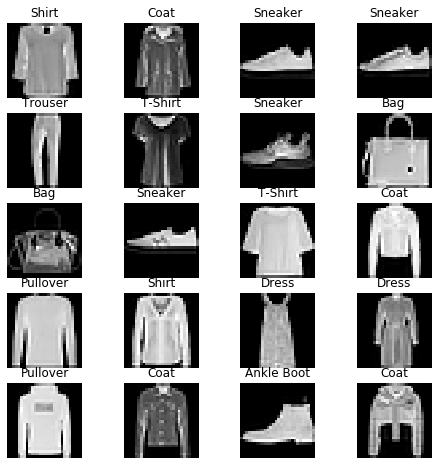

In [ ]:
#Visualize dataset
data_set = list(zip(trainx,trainy))
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}; #labels taken from https://github.com/zalandoresearch/fashion-mnist
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(data_set));
    img = data_set[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[data_set[img_xy][1].item()])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

# Q1

## 1. Setting up Training Function

In [ ]:
def calc_acc(loader, net):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for images, labels in loader:
            images,labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return ((100*correct)/total)

In [ ]:
def calc_loss(loader, net):
    net.eval()
    batchloss = 0
    for images,labels in loader:
        images,labels = images.to(device), labels.to(device)
        outputs = net(images)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        batchloss += loss.item()
    epochloss = batchloss /len(loader)
    return epochloss

In [ ]:
def train(net, epochs, loss_function, modelname, device, save_name=None):
    train_loss=[]
    valid_loss=[]
    #test_loss=[]
    train_acc=[]
    valid_acc=[]
    test_acc=[]
    total_i = 0
    max_acc = 0
    for epoch in range(epochs):
        net.train()
        running_loss = 0
        nr_batches = 0
        for i, data in enumerate(train_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            optimizer.zero_grad()
            outputs = net(images)

            loss = loss_function(outputs, labels)
            
            # Backward Grad
            loss.backward()
            # Update grad
            optimizer.step()
            running_loss += loss.cpu().item()
            nr_batches+=1
        # PER EPOCH
        net.eval()
        with torch.no_grad():
          # Append
          train_loss.append(running_loss/nr_batches)
          valid_loss.append(calc_loss(valid_loader,net))
          
          train_acc.append(calc_acc(train_loader, net))
          acc_val = calc_acc(valid_loader, net)
          valid_acc.append(acc_val)

          if save_name is not None and acc_val > max_acc:
            max_acc = acc_val
            torch.save(model, save_name)

          print('Epoch: %d of %d, Train Loss: %0.3f, Valid Loss: %0.3f, Train Acc: %0.3f, Valid Acc: %0.3f'
                % (epoch+1, epochs, train_loss[epoch], valid_loss[epoch], train_acc[epoch], valid_acc[epoch]))
          
    result = {'trainloss':train_loss, 'validloss': valid_loss, 'trainacc': train_acc, 'validacc':valid_acc, 'name': modelname}   
    return result

## 2. Creating a Baseline Network

In [ ]:
class Model1(nn.Module):
    def __init__(self,num_classes=5):
        super(Model1, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)) 
        self.layer2 = nn.Sequential( 
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)) 
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4*4*32, out_features=312),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=312, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Reshape output from previous layer to fit fully connected layer input
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Summary of the Model-1
model = Model1().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              ReLU-2           [-1, 20, 24, 24]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          16,032
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
           Dropout-7                  [-1, 512]               0
            Linear-8                  [-1, 312]         160,056
              ReLU-9                  [-1, 312]               0
          Dropout-10                  [-1, 312]               0
           Linear-11                   [-1, 64]          20,032
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 5]             325
Total params: 196,965
Trainable params:

## 3. Training the Baseline Model

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline Model"
save_name = "base_line.pth"
model = Model1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, 
                             weight_decay=0, amsgrad=False) # Basic Adam Optimiser

# Run the Model
start = time.time()
baseline_list = train(model,epochs,loss_function,name,device, save_name)
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 0.720, Valid Loss: 0.138, Train Acc: 95.800, Valid Acc: 95.900
Epoch: 2 of 150, Train Loss: 0.176, Valid Loss: 0.118, Train Acc: 96.456, Valid Acc: 96.239
Epoch: 3 of 150, Train Loss: 0.136, Valid Loss: 0.081, Train Acc: 97.618, Valid Acc: 97.413
Epoch: 4 of 150, Train Loss: 0.126, Valid Loss: 0.074, Train Acc: 98.050, Valid Acc: 97.811
Epoch: 5 of 150, Train Loss: 0.115, Valid Loss: 0.073, Train Acc: 98.098, Valid Acc: 97.811
Epoch: 6 of 150, Train Loss: 0.102, Valid Loss: 0.064, Train Acc: 98.422, Valid Acc: 97.930
Epoch: 7 of 150, Train Loss: 0.094, Valid Loss: 0.064, Train Acc: 98.555, Valid Acc: 98.030
Epoch: 8 of 150, Train Loss: 0.084, Valid Loss: 0.061, Train Acc: 98.619, Valid Acc: 98.129
Epoch: 9 of 150, Train Loss: 0.090, Valid Loss: 0.058, Train Acc: 98.735, Valid Acc: 98.169
Epoch: 10 of 150, Train Loss: 0.077, Valid Loss: 0.063, Train Acc: 98.623, Valid Acc: 98.010
Epoch: 11 of 150, Train Loss: 0.077, Valid Loss: 0.064, Train Acc: 98.619, Vali

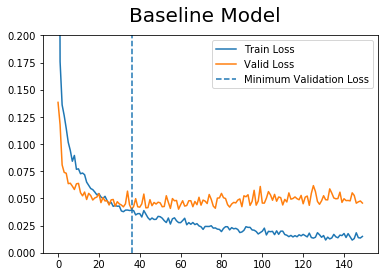

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0,0.039141,0.039965,0.045955,99.611612,98.746269,99.02


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = baseline_list
#======================================================

# Plot Model
def plot_model(model):
    rang = len(model['validacc'])
    plt.plot(list(range(rang)), model['trainloss'], label='Train Loss')
    plt.plot(list(range(rang)), model['validloss'], label='Valid Loss')
    plt.ylim(0, 0.2)
    min_valloss = min(model["validloss"])
    min_idx = model["validloss"].index(min_valloss)
    plt.axvline(x=min_idx, label="Minimum Validation Loss",linestyle='dashed')
    plt.legend(loc='upper right')
    plt.suptitle(model['name'],fontsize=20)
    plt.show()
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m = torch.load("base_line.pth")
# Create Dictionary 
baseline = {'Name':'Baseline',
          'Convolution':'Model-1',
          'Classification':'Model-1',
          'Optimiser':'Adam',
          'L.rate':0.001,
          'Regularisation':0,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss': calc_loss(test_loader, m), 
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc': calc_acc(test_loader, m) }

# Create Table
variant_table = pd.DataFrame([baseline])
variant_table.index += 1
variant_table

* This model will be the baseline model in which I will make modifications and observe what effects they'll have.
* The architecture of this baseline CNN model is built through trial-and-error, as some architecture did not lead to convergence of training loss.
* Training loss converges well, whereas validation loss slowly increases. This is the sign of overfitting, therefore the best model is selected by selecting the lowest validation loss.   
* **I set up the scale of the graph to be 0 to 0.2. This was to closely observe the behavior of the validation loss. When the graph is scaled 0 to 1, the validation loss and the train loss would look close to each other.**     


#Q2
We now iteratively make modifications to the baseline model based on how the changes affect the validation loss

### Model #2: Baseline Model with L2 Regularisation (0.0005)

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline with L2 Regularisation=0.0005"

l2reg_1 = Model1().to(device)
optimizer = torch.optim.Adam(l2reg_1.parameters(), lr=0.001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0.0005, amsgrad=False) # Only modified weight_decay

# Run the Model
start = time.time()
l2reg_1_list = train(l2reg_1,epochs,loss_function,name,device, "m2.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 0.557, Valid Loss: 0.113, Train Acc: 96.573, Valid Acc: 96.517
Epoch: 2 of 150, Train Loss: 0.181, Valid Loss: 0.091, Train Acc: 97.081, Valid Acc: 97.114
Epoch: 3 of 150, Train Loss: 0.137, Valid Loss: 0.078, Train Acc: 97.570, Valid Acc: 97.552
Epoch: 4 of 150, Train Loss: 0.121, Valid Loss: 0.090, Train Acc: 97.397, Valid Acc: 97.234
Epoch: 5 of 150, Train Loss: 0.107, Valid Loss: 0.065, Train Acc: 98.382, Valid Acc: 98.129
Epoch: 6 of 150, Train Loss: 0.101, Valid Loss: 0.061, Train Acc: 98.511, Valid Acc: 98.109
Epoch: 7 of 150, Train Loss: 0.088, Valid Loss: 0.061, Train Acc: 98.599, Valid Acc: 98.010
Epoch: 8 of 150, Train Loss: 0.086, Valid Loss: 0.060, Train Acc: 98.679, Valid Acc: 98.010
Epoch: 9 of 150, Train Loss: 0.077, Valid Loss: 0.063, Train Acc: 98.611, Valid Acc: 98.010
Epoch: 10 of 150, Train Loss: 0.073, Valid Loss: 0.059, Train Acc: 98.843, Valid Acc: 98.030
Epoch: 11 of 150, Train Loss: 0.070, Valid Loss: 0.064, Train Acc: 98.663, Vali

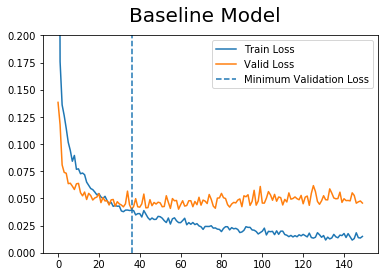

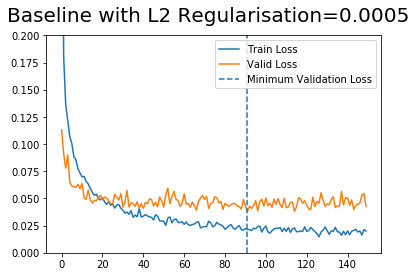

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.001,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = l2reg_1_list
#======================================================

# Plot
plot_model(baseline_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m2 = torch.load("m2.pth")
# Create Dictionary 
l2reg_1model = {'Name':thismodel['name'],
          'Convolution':'Model-1',
          'Classification':'Model-1',
          'Optimiser':'Adam',
          'L.rate':0.001,
          'Regularisation':0.0005,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss': calc_loss(test_loader, m2),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m2)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model])
variant_table.index += 1
variant_table

* 0.0005 refers to the lamda value, which is multiplied to the sum of squared differences between the actual value and predicted value. They act as penalty term to the loss function, preventing the model from overfitting to the training loss. 
* Therefore, the L2 regularisation=0.0005 is producing a validation loss graph that does not increase as much as the baseline model. In other words, the model is  less overfitting on the training loss. This is because regularisation penalizes the loss function, thus discouraging the complexity of the model and solves overfitting problem. 
* The validation accuracy is higher than that of the baseline model.



Let's now compare different lamda value of L2 regulrisation.

### Model #3: Baseline Model with L2 Regularisation (0.004)

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline with L2 Regularisation=0.004"

l2_reg2 = Model1().to(device)
optimizer = torch.optim.Adam(l2_reg2.parameters(), lr=0.001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0.004, amsgrad=False) # Only modified weight_decay

# Run the Model
start = time.time()
l2_reg2_list = train(l2_reg2,epochs,loss_function,name,device, "m3.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 0.560, Valid Loss: 0.126, Train Acc: 96.400, Valid Acc: 96.318
Epoch: 2 of 150, Train Loss: 0.163, Valid Loss: 0.107, Train Acc: 97.221, Valid Acc: 96.935
Epoch: 3 of 150, Train Loss: 0.139, Valid Loss: 0.077, Train Acc: 97.906, Valid Acc: 97.652
Epoch: 4 of 150, Train Loss: 0.111, Valid Loss: 0.073, Train Acc: 98.122, Valid Acc: 97.751
Epoch: 5 of 150, Train Loss: 0.105, Valid Loss: 0.070, Train Acc: 98.174, Valid Acc: 98.030
Epoch: 6 of 150, Train Loss: 0.101, Valid Loss: 0.066, Train Acc: 98.414, Valid Acc: 97.910
Epoch: 7 of 150, Train Loss: 0.094, Valid Loss: 0.067, Train Acc: 98.314, Valid Acc: 97.891
Epoch: 8 of 150, Train Loss: 0.089, Valid Loss: 0.060, Train Acc: 98.615, Valid Acc: 97.990
Epoch: 9 of 150, Train Loss: 0.086, Valid Loss: 0.058, Train Acc: 98.603, Valid Acc: 98.229
Epoch: 10 of 150, Train Loss: 0.079, Valid Loss: 0.060, Train Acc: 98.643, Valid Acc: 98.090
Epoch: 11 of 150, Train Loss: 0.077, Valid Loss: 0.055, Train Acc: 98.735, Vali

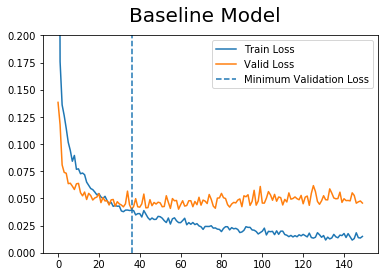

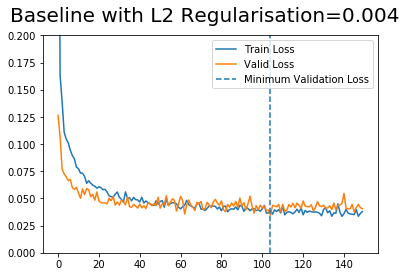

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.001,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.001,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = l2_reg2_list
#======================================================

# Plot
plot_model(baseline_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m3 = torch.load("m3.pth")
# Create Dictionary 
l2reg2 = {'Name':thismodel['name'],
          'Convolution':'Model-1',
          'Classification':'Model-1',
          'Optimiser':'Adam',
          'L.rate':0.001,
          'Regularisation':0.004,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss': calc_loss(test_loader, m3),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m3)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2])

variant_table.index += 1
variant_table

* It's stated in the Leslie Smith [paper](https://arxiv.org/pdf/1803.09820.pdf) that weight_decay=0.004 is often used.
* Compared to the baseline model, we see that oscillation is much more suppressed, and overfitting is significantly decreased.
* The validation accuracy reached impressive 99%. The previous model (Baseline Model with L2 Regularisation(0.0005)) also achieved 99%, but we choose this model(Baseline model with L2 Regularisation (0.004)) as a frontrunner model because it is more robust with reduced oscillation and improvement on overfitting. 
* Given the data and model parameters, we choose weight_decay=0.004 over weight_decay=0.0005.


What would happen if we use a different optimiser? Using a different optimiser means we would be using different hyperparameters, such as learning rate, regularisation value, running average of squared gradients, etc.

### Model #4: Baseline Model with Adadelta Optimiser

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline with Adadelta Optimiser"

adadmodel = Model1().to(device)
optimizer = torch.optim.Adadelta(adadmodel.parameters(), lr=1.0, rho=0.9, 
                                 eps=1e-06, weight_decay=0) #Basic Adadelta

# Run the Model
start = time.time()
adadmodel_list = train(adadmodel,epochs,loss_function,name,device, "m4.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 0.691, Valid Loss: 0.128, Train Acc: 96.348, Valid Acc: 96.279
Epoch: 2 of 150, Train Loss: 0.174, Valid Loss: 0.086, Train Acc: 97.518, Valid Acc: 97.532
Epoch: 3 of 150, Train Loss: 0.122, Valid Loss: 0.085, Train Acc: 98.066, Valid Acc: 97.731
Epoch: 4 of 150, Train Loss: 0.102, Valid Loss: 0.074, Train Acc: 98.150, Valid Acc: 97.751
Epoch: 5 of 150, Train Loss: 0.092, Valid Loss: 0.082, Train Acc: 98.070, Valid Acc: 97.771
Epoch: 6 of 150, Train Loss: 0.081, Valid Loss: 0.076, Train Acc: 98.298, Valid Acc: 97.970
Epoch: 7 of 150, Train Loss: 0.075, Valid Loss: 0.059, Train Acc: 98.867, Valid Acc: 98.328
Epoch: 8 of 150, Train Loss: 0.065, Valid Loss: 0.060, Train Acc: 98.999, Valid Acc: 98.388
Epoch: 9 of 150, Train Loss: 0.065, Valid Loss: 0.059, Train Acc: 99.055, Valid Acc: 98.408
Epoch: 10 of 150, Train Loss: 0.062, Valid Loss: 0.058, Train Acc: 99.167, Valid Acc: 98.667
Epoch: 11 of 150, Train Loss: 0.058, Valid Loss: 0.056, Train Acc: 99.239, Vali

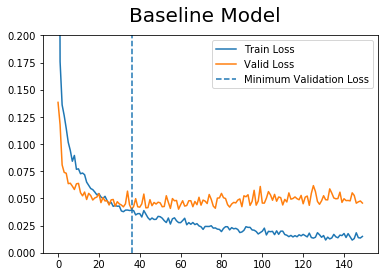

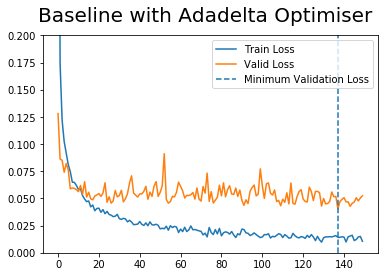

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.001,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.001,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.90
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = adadmodel_list
#======================================================

# Plot Model
plot_model(baseline_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m4 = torch.load("m4.pth")
# Create Dictionary 
adamodel = {'Name':thismodel['name'],
          'Convolution':'Model-1',
          'Classification':'Model-1',
          'Optimiser':'Adadelta',
          'L.rate':1.0,
          'Regularisation':0,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss': calc_loss(test_loader, m4),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m4)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2,adamodel])
variant_table.index += 1
variant_table

* According to Zeiler's 2012 [paper](https://arxiv.org/abs/1212.5701), Adadelta Optimiser is a per-dimension learning rate method for gradient descent. It restricts the window of accumulated past gradients to some fixed size value.
* Compared to the baseline model, validation loss oscillates more heavily and the model is more overfitting the training data as epochs run. Oscillation and overfitting of the loss graph implies that the model is less robust.

What about a different optimiser? SGD optimiser is an optimiser that is frequently used.

### Model #5: Baseline Model with Adagrad Optimiser



In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline Model with Adagrad Optimiser"

adagrad = Model1().to(device)
optimizer = torch.optim.Adagrad(adagrad.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10) # Basic SGD

# Run the Model
start = time.time()
adagrad_list = train(adagrad,epochs,loss_function,name,device, "m5.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 1.376, Valid Loss: 0.148, Train Acc: 95.580, Valid Acc: 95.642
Epoch: 2 of 150, Train Loss: 0.210, Valid Loss: 0.117, Train Acc: 96.344, Valid Acc: 96.259
Epoch: 3 of 150, Train Loss: 0.164, Valid Loss: 0.098, Train Acc: 97.221, Valid Acc: 97.234
Epoch: 4 of 150, Train Loss: 0.150, Valid Loss: 0.086, Train Acc: 97.690, Valid Acc: 97.433
Epoch: 5 of 150, Train Loss: 0.133, Valid Loss: 0.083, Train Acc: 97.838, Valid Acc: 97.632
Epoch: 6 of 150, Train Loss: 0.126, Valid Loss: 0.086, Train Acc: 97.702, Valid Acc: 97.493
Epoch: 7 of 150, Train Loss: 0.119, Valid Loss: 0.080, Train Acc: 97.906, Valid Acc: 97.572
Epoch: 8 of 150, Train Loss: 0.108, Valid Loss: 0.074, Train Acc: 98.046, Valid Acc: 97.751
Epoch: 9 of 150, Train Loss: 0.104, Valid Loss: 0.071, Train Acc: 98.278, Valid Acc: 97.791
Epoch: 10 of 150, Train Loss: 0.100, Valid Loss: 0.067, Train Acc: 98.302, Valid Acc: 98.030
Epoch: 11 of 150, Train Loss: 0.099, Valid Loss: 0.069, Train Acc: 98.302, Vali

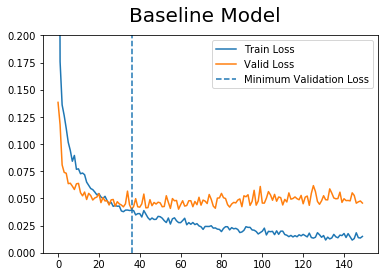

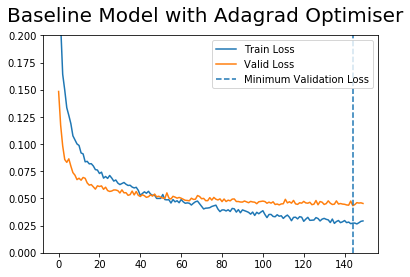

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.001,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.001,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.90
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.90
5,Baseline Model with Adagrad Optimiser,Model-1,Model-1,Adagrad,0.010,0.0000,0.027284,0.043334,0.043241,99.787788,98.626866,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = adagrad_list
#======================================================

# Plot Model
plot_model(baseline_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m5 = torch.load("m5.pth")
# Create Dictionary 
adagradmodel = {'Name':thismodel['name'],
          'Convolution':'Model-1',
          'Classification':'Model-1',
          'Optimiser':'Adagrad',
          'L.rate':0.01,
          'Regularisation':0,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss':calc_loss(test_loader, m5),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m5)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2,adamodel,adagradmodel])
variant_table.index += 1
variant_table

* According to [Sebastian Ruder,](https://ruder.io/optimizing-gradient-descent/index.html#adagrad) Adagrad optimizer "adapts the learning rate to the parameters, performing smaller updates
(i.e. low learning rates) for parameters associated with frequently occurring features, and larger updates (i.e. high learning rates) for parameters associated with infrequent features."
* The learning rate smoothes out the optimization process, slowing updates to continue in the previous direction. While doing that it prevents getting stuck in local optima and reduces oscilation in loss.
* This adaptive optimzer has a very smooth loss graph, however did not produce an improve in validation accuracy. 



### Model #6: Baseline Model with Different Dropout Rate (0.2)

In [ ]:
class Model1_dropout(nn.Module):
    def __init__(self,num_classes=5):
        super(Model1_dropout, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential( 
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4*4*32, out_features=312),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=312, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Reshape output from previous layer to fit fully connected layer input
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline Model with dropout=0.2"

dropout = Model1_dropout().to(device)
optimizer = torch.optim.Adam(dropout.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, 
                             weight_decay=0, amsgrad=False) # Basic Adam Optimiser

# Run the Model
start = time.time()
dropout_list = train(dropout,epochs,loss_function,name,device, "m6.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 0.542, Valid Loss: 0.103, Train Acc: 96.905, Valid Acc: 97.015
Epoch: 2 of 150, Train Loss: 0.112, Valid Loss: 0.083, Train Acc: 97.798, Valid Acc: 97.632
Epoch: 3 of 150, Train Loss: 0.094, Valid Loss: 0.077, Train Acc: 98.058, Valid Acc: 97.692
Epoch: 4 of 150, Train Loss: 0.080, Valid Loss: 0.066, Train Acc: 98.511, Valid Acc: 98.090
Epoch: 5 of 150, Train Loss: 0.069, Valid Loss: 0.063, Train Acc: 98.715, Valid Acc: 98.090
Epoch: 6 of 150, Train Loss: 0.065, Valid Loss: 0.069, Train Acc: 98.739, Valid Acc: 98.209
Epoch: 7 of 150, Train Loss: 0.057, Valid Loss: 0.058, Train Acc: 98.947, Valid Acc: 98.269
Epoch: 8 of 150, Train Loss: 0.059, Valid Loss: 0.057, Train Acc: 98.851, Valid Acc: 98.328
Epoch: 9 of 150, Train Loss: 0.049, Valid Loss: 0.054, Train Acc: 99.135, Valid Acc: 98.507
Epoch: 10 of 150, Train Loss: 0.045, Valid Loss: 0.058, Train Acc: 99.215, Valid Acc: 98.507
Epoch: 11 of 150, Train Loss: 0.042, Valid Loss: 0.052, Train Acc: 99.263, Vali

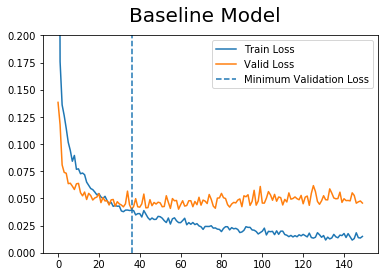

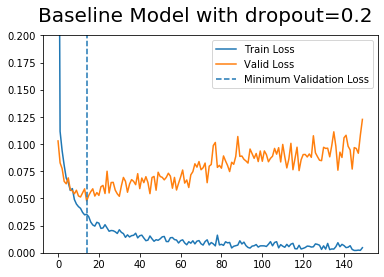

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.001,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.001,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.90
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.90
5,Baseline Model with Adagrad Optimiser,Model-1,Model-1,Adagrad,0.010,0.0000,0.027284,0.043334,0.043241,99.787788,98.626866,98.90
6,Baseline Model with dropout=0.2,Model-1,Model-1 with dropout rate=0.2,Adam,0.001,0.0000,0.035430,0.047695,0.043130,99.467467,98.646766,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = dropout_list
#======================================================

# Plot Model
plot_model(baseline_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m6 = torch.load("m6.pth")
# Create Dictionary 
dropoutmodel = {'Name':thismodel['name'],
          'Convolution':'Model-1',
          'Classification':'Model-1 with dropout rate=0.2',
          'Optimiser':'Adam',
          'L.rate':0.001,
          'Regularisation':0,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss':calc_loss(test_loader, m6),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m6)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2,adamodel,adagradmodel,dropoutmodel])
variant_table.index += 1
variant_table

* The dropout rate of the baseline model is 0.5. Compared to the baseline model, the dropout rate of 0.2 produces a validation loss graph that is heavily oscilating, and the model that is overfitting the training data.
* Dropout rate refers to the portion of the retaining outputs from the layer. Given the parameters, dropout rate of 0.2 does not work well with this model.

### Model #7: Baseline Model with Different Dropout Rate (0.7)


In [ ]:
class Model2_dropout(nn.Module):
    def __init__(self,num_classes=5):
        super(Model2_dropout, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential( 
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4*4*32, out_features=312),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=312, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Reshape output from previous layer to fit fully connected layer input
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline Model with dropout=0.7"

dropout2 = Model2_dropout().to(device)
optimizer = torch.optim.Adam(dropout2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, 
                             weight_decay=0, amsgrad=False) # Basic Adam Optimiser

# Run the Model
start = time.time()
dropout2_list = train(dropout2,epochs,loss_function,name,device, "m7.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 0.390, Valid Loss: 0.092, Train Acc: 97.313, Valid Acc: 96.935
Epoch: 2 of 150, Train Loss: 0.097, Valid Loss: 0.067, Train Acc: 98.230, Valid Acc: 97.791
Epoch: 3 of 150, Train Loss: 0.077, Valid Loss: 0.066, Train Acc: 98.623, Valid Acc: 98.090
Epoch: 4 of 150, Train Loss: 0.065, Valid Loss: 0.069, Train Acc: 98.755, Valid Acc: 98.030
Epoch: 5 of 150, Train Loss: 0.054, Valid Loss: 0.054, Train Acc: 99.151, Valid Acc: 98.468
Epoch: 6 of 150, Train Loss: 0.049, Valid Loss: 0.048, Train Acc: 99.291, Valid Acc: 98.428
Epoch: 7 of 150, Train Loss: 0.045, Valid Loss: 0.049, Train Acc: 99.283, Valid Acc: 98.567
Epoch: 8 of 150, Train Loss: 0.038, Valid Loss: 0.060, Train Acc: 99.183, Valid Acc: 98.308
Epoch: 9 of 150, Train Loss: 0.039, Valid Loss: 0.056, Train Acc: 99.319, Valid Acc: 98.328
Epoch: 10 of 150, Train Loss: 0.036, Valid Loss: 0.049, Train Acc: 99.548, Valid Acc: 98.567
Epoch: 11 of 150, Train Loss: 0.035, Valid Loss: 0.058, Train Acc: 99.307, Vali

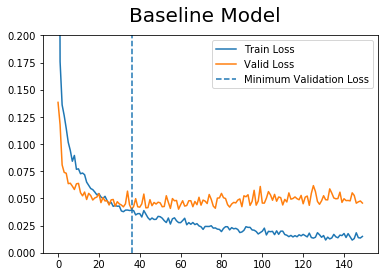

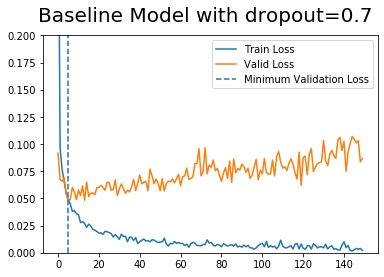

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.001,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.001,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.90
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.90
5,Baseline Model with Adagrad Optimiser,Model-1,Model-1,Adagrad,0.010,0.0000,0.027284,0.043334,0.043241,99.787788,98.626866,98.90
6,Baseline Model with dropout=0.2,Model-1,Model-1 with dropout rate=0.2,Adam,0.001,0.0000,0.035430,0.047695,0.043130,99.467467,98.646766,98.90
7,Baseline Model with dropout=0.7,Model-1,Model-1 with dropout rate=0.7,Adam,0.001,0.0000,0.048995,0.047878,0.043508,99.291291,98.427861,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = dropout2_list
#======================================================

# Plot Model
plot_model(baseline_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m7 = torch.load("m7.pth")
# Create Dictionary 
dropout2model = {'Name':thismodel['name'],
          'Convolution':'Model-1',
          'Classification':'Model-1 with dropout rate=0.7',
          'Optimiser':'Adam',
          'L.rate':0.001,
          'Regularisation':0,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss':calc_loss(test_loader, m7),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m7)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2,adamodel,adagradmodel,dropoutmodel,dropout2model])
variant_table.index += 1
variant_table

* Similar to Dropout rate of 0.2, dropout rate of 0.7 did not work well with this model. The model is overfitting to the training loss, and heaviliy oscillating.

### Model #8: LeNet

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.cnn_model = nn.Sequential(
      nn.Conv2d(1, 6, kernel_size = 5), 
      nn.Tanh(),
      nn.AvgPool2d(2, stride = 2),
      nn.Conv2d(6, 16, kernel_size = 5), 
      nn.Tanh(),
      nn.AvgPool2d(2, stride = 2))
    self.fc_model = nn.Sequential(
      nn.Linear(256, 120), 
      nn.Tanh(),
      nn.Linear(120, 84),
      nn.Tanh(),
      nn.Linear(84, 5))
  def forward(self, x):     
    x = self.cnn_model(x)     
    x = x.view(x.size(0), -1)     
    x = self.fc_model(x)     
    return x

# Summary of LeNet
model_6 = LeNet().to(device)
summary(model_6, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              Tanh-2            [-1, 6, 24, 24]               0
         AvgPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              Tanh-5             [-1, 16, 8, 8]               0
         AvgPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              Tanh-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                    [-1, 5]             425
Total params: 44,001
Trainable params: 44,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "LeNet"

lenet = LeNet().to(device)
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, 
                             weight_decay=0, amsgrad=False) # Basic Adam Optimiser

# Run the Model
start = time.time()
lenet_list = train(lenet,epochs,loss_function,name,device, "m8.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 0.360, Valid Loss: 0.098, Train Acc: 97.245, Valid Acc: 97.333
Epoch: 2 of 150, Train Loss: 0.090, Valid Loss: 0.084, Train Acc: 97.594, Valid Acc: 97.413
Epoch: 3 of 150, Train Loss: 0.078, Valid Loss: 0.083, Train Acc: 97.890, Valid Acc: 97.512
Epoch: 4 of 150, Train Loss: 0.066, Valid Loss: 0.068, Train Acc: 98.258, Valid Acc: 98.149
Epoch: 5 of 150, Train Loss: 0.062, Valid Loss: 0.069, Train Acc: 98.306, Valid Acc: 97.950
Epoch: 6 of 150, Train Loss: 0.057, Valid Loss: 0.060, Train Acc: 98.470, Valid Acc: 98.169
Epoch: 7 of 150, Train Loss: 0.053, Valid Loss: 0.060, Train Acc: 98.555, Valid Acc: 98.249
Epoch: 8 of 150, Train Loss: 0.050, Valid Loss: 0.058, Train Acc: 98.687, Valid Acc: 98.249
Epoch: 9 of 150, Train Loss: 0.044, Valid Loss: 0.058, Train Acc: 98.779, Valid Acc: 98.209
Epoch: 10 of 150, Train Loss: 0.044, Valid Loss: 0.065, Train Acc: 98.498, Valid Acc: 97.970
Epoch: 11 of 150, Train Loss: 0.045, Valid Loss: 0.055, Train Acc: 98.907, Vali

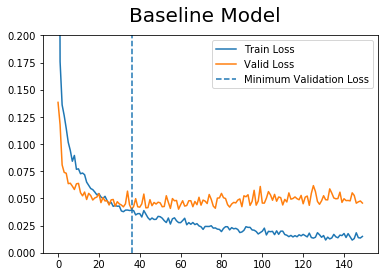

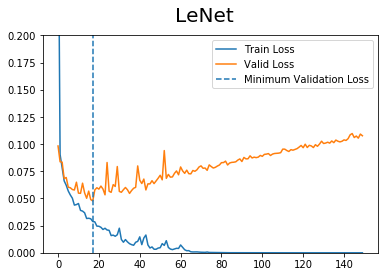

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.001,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.001,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.001,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.90
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.90
5,Baseline Model with Adagrad Optimiser,Model-1,Model-1,Adagrad,0.010,0.0000,0.027284,0.043334,0.043241,99.787788,98.626866,98.90
6,Baseline Model with dropout=0.2,Model-1,Model-1 with dropout rate=0.2,Adam,0.001,0.0000,0.035430,0.047695,0.043130,99.467467,98.646766,98.90
7,Baseline Model with dropout=0.7,Model-1,Model-1 with dropout rate=0.7,Adam,0.001,0.0000,0.048995,0.047878,0.043508,99.291291,98.427861,98.90
8,LeNet,LeNet,LeNet,Adam,0.001,0.0000,0.028736,0.047710,0.043538,99.255255,98.686567,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = lenet_list
#======================================================

# Plot Model
plot_model(baseline_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m8 = torch.load("m8.pth")
# Create Dictionary 
lenetmodel = {'Name':thismodel['name'],
          'Convolution':'LeNet',
          'Classification':'LeNet',
          'Optimiser':'Adam',
          'L.rate':0.001,
          'Regularisation':0,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss':calc_loss(test_loader, m8),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m8)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2,adamodel,adagradmodel,dropoutmodel,dropout2model,lenetmodel])
variant_table.index += 1
variant_table

* Lenet-5 is a pioneering 7-level CNN by LeCun et al. in 1998. This model was used by banks to recognize handwritten digits on checks.
* However, given the parameters of the model and the data, changing the CNN architecture to Lenet-5 does not seem to work well. The validation accuracy is lower, and after around 20 epochs the model overfits heavily to the training loss. 

***From here on, we make modifications to model#3 Baseline Model with L2 Regularisation(0.004), as it proved to be the most successful. ***

### Model #9: Baseline Model with L2 Regularisation (0.004) and Different Learning Rate (0.0001)

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline with L2 Reg=0.004 and LR=0.0001"

l2regLR = Model1().to(device)
optimizer = torch.optim.Adam(l2regLR.parameters(), lr=0.0001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0.004, amsgrad=False)

# Run the Model
start = time.time()
l2regLR_list = train(l2regLR,epochs,loss_function,name,device, "m9.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-

Epoch: 1 of 150, Train Loss: 1.643, Valid Loss: 0.323, Train Acc: 89.409, Valid Acc: 89.393
Epoch: 2 of 150, Train Loss: 0.393, Valid Loss: 0.179, Train Acc: 94.186, Valid Acc: 94.129
Epoch: 3 of 150, Train Loss: 0.271, Valid Loss: 0.140, Train Acc: 95.568, Valid Acc: 95.423
Epoch: 4 of 150, Train Loss: 0.219, Valid Loss: 0.121, Train Acc: 96.168, Valid Acc: 95.721
Epoch: 5 of 150, Train Loss: 0.189, Valid Loss: 0.104, Train Acc: 96.861, Valid Acc: 96.637
Epoch: 6 of 150, Train Loss: 0.169, Valid Loss: 0.103, Train Acc: 96.813, Valid Acc: 96.597
Epoch: 7 of 150, Train Loss: 0.155, Valid Loss: 0.090, Train Acc: 97.249, Valid Acc: 96.995
Epoch: 8 of 150, Train Loss: 0.141, Valid Loss: 0.082, Train Acc: 97.526, Valid Acc: 97.274
Epoch: 9 of 150, Train Loss: 0.134, Valid Loss: 0.081, Train Acc: 97.562, Valid Acc: 97.313
Epoch: 10 of 150, Train Loss: 0.125, Valid Loss: 0.080, Train Acc: 97.754, Valid Acc: 97.433
Epoch: 11 of 150, Train Loss: 0.117, Valid Loss: 0.074, Train Acc: 97.842, Vali

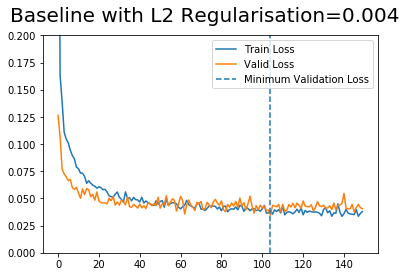

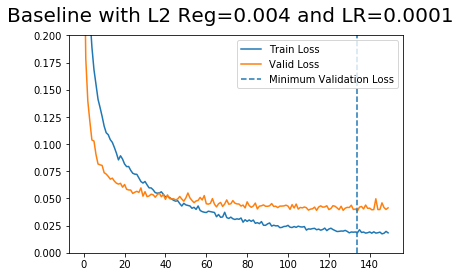

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.0010,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.02
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.0010,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.90
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.0010,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.90
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.0000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.90
5,Baseline Model with Adagrad Optimiser,Model-1,Model-1,Adagrad,0.0100,0.0000,0.027284,0.043334,0.043241,99.787788,98.626866,98.90
6,Baseline Model with dropout=0.2,Model-1,Model-1 with dropout rate=0.2,Adam,0.0010,0.0000,0.035430,0.047695,0.043130,99.467467,98.646766,98.90
7,Baseline Model with dropout=0.7,Model-1,Model-1 with dropout rate=0.7,Adam,0.0010,0.0000,0.048995,0.047878,0.043508,99.291291,98.427861,98.90
8,LeNet,LeNet,LeNet,Adam,0.0010,0.0000,0.028736,0.047710,0.043538,99.255255,98.686567,98.90
9,Baseline with L2 Reg=0.004 and LR=0.0001,Model-1,Model-1,Adam,0.0001,0.0040,0.018428,0.038460,0.045133,99.883884,98.865672,98.90


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = l2regLR_list
#======================================================

# Plot
plot_model(l2_reg2_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m9 = torch.load("m9.pth")
# Create Dictionary 
l2regLRmodel = {'Name':thismodel['name'],
          'Convolution':'Model-1',
          'Classification':'Model-1',
          'Optimiser':'Adam',
          'L.rate':0.0001,
          'Regularisation':0.004,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss':calc_loss(test_loader, m9),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_acc(test_loader, m9)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2,adamodel,adagradmodel,dropoutmodel,dropout2model,lenetmodel,l2regLRmodel])
variant_table.index += 1
variant_table

* This model #9 has everything the same as the frontrunner model (model #3) but the learning rate changed from 0.001 to 0.0001.  
* I've previously tried learning rate of 0.1 and 0.01, but training loss did not converge, neither the validation loss.
* The learning rate of 0.0001 creates a very smooth loss, however the absence of oscillation did not produce a higher validation accuracy. Therefore, we keep model#3 as the the frontrunner model, as its validation accuracy is 99%.

### Model#10: Baseline Model with L2 Regularisation (0.004) and different activation function

In [ ]:
class diffActivation(nn.Module):
    def __init__(self,num_classes=5):
        super(diffActivation, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2,stride=2)) 
        self.layer2 = nn.Sequential( 
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=5), 
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2,stride=2)) 
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4*4*32, out_features=312),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=312, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Reshape output from previous layer to fit fully connected layer input
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Summary of the Model-1
model = diffActivation().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              Tanh-2           [-1, 20, 24, 24]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          16,032
              Tanh-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
           Dropout-7                  [-1, 512]               0
            Linear-8                  [-1, 312]         160,056
              Tanh-9                  [-1, 312]               0
          Dropout-10                  [-1, 312]               0
           Linear-11                   [-1, 64]          20,032
             Tanh-12                   [-1, 64]               0
           Linear-13                    [-1, 5]             325
Total params: 196,965
Trainable params:

In [ ]:
# Model Setup
epochs = 150
loss_function = nn.CrossEntropyLoss()
name = "Baseline with L2 Reg=0.004 and different Act Function"

diffact = diffActivation().to(device)
optimizer = torch.optim.Adam(diffact.parameters(), lr=0.001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0.004, amsgrad=False)

# Run the Model
start = time.time()
diffact_list = train(diffact,epochs,loss_function,name,device, "m10.pth")
end = time.time()

print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type diffActivation. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3

Epoch: 1 of 150, Train Loss: 0.279, Valid Loss: 0.093, Train Acc: 97.710, Valid Acc: 97.473
Epoch: 2 of 150, Train Loss: 0.100, Valid Loss: 0.085, Train Acc: 97.734, Valid Acc: 97.473
Epoch: 3 of 150, Train Loss: 0.085, Valid Loss: 0.078, Train Acc: 98.230, Valid Acc: 97.791
Epoch: 4 of 150, Train Loss: 0.077, Valid Loss: 0.070, Train Acc: 98.414, Valid Acc: 97.990
Epoch: 5 of 150, Train Loss: 0.073, Valid Loss: 0.065, Train Acc: 98.603, Valid Acc: 98.109
Epoch: 6 of 150, Train Loss: 0.070, Valid Loss: 0.064, Train Acc: 98.503, Valid Acc: 98.209
Epoch: 7 of 150, Train Loss: 0.069, Valid Loss: 0.064, Train Acc: 98.663, Valid Acc: 98.070
Epoch: 8 of 150, Train Loss: 0.064, Valid Loss: 0.068, Train Acc: 98.378, Valid Acc: 97.990
Epoch: 9 of 150, Train Loss: 0.062, Valid Loss: 0.059, Train Acc: 98.791, Valid Acc: 98.209
Epoch: 10 of 150, Train Loss: 0.057, Valid Loss: 0.054, Train Acc: 98.923, Valid Acc: 98.388
Epoch: 11 of 150, Train Loss: 0.060, Valid Loss: 0.060, Train Acc: 98.787, Vali

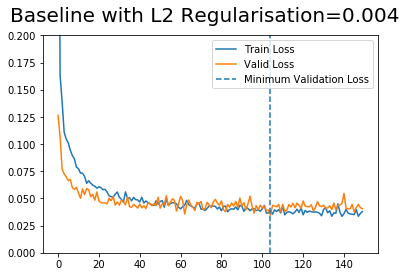

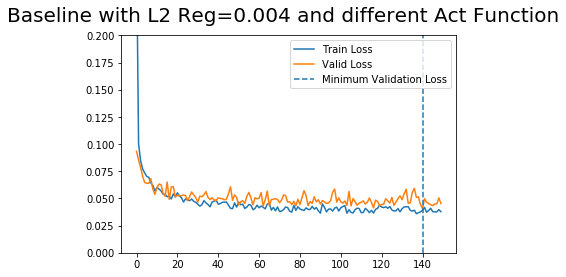

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.0010,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.020000
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.0010,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.900000
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.0010,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.900000
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.0000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.900000
5,Baseline Model with Adagrad Optimiser,Model-1,Model-1,Adagrad,0.0100,0.0000,0.027284,0.043334,0.043241,99.787788,98.626866,98.900000
6,Baseline Model with dropout=0.2,Model-1,Model-1 with dropout rate=0.2,Adam,0.0010,0.0000,0.035430,0.047695,0.043130,99.467467,98.646766,98.900000
7,Baseline Model with dropout=0.7,Model-1,Model-1 with dropout rate=0.7,Adam,0.0010,0.0000,0.048995,0.047878,0.043508,99.291291,98.427861,98.900000
8,LeNet,LeNet,LeNet,Adam,0.0010,0.0000,0.028736,0.047710,0.043538,99.255255,98.686567,98.900000
9,Baseline with L2 Reg=0.004 and LR=0.0001,Model-1,Model-1,Adam,0.0001,0.0040,0.018428,0.038460,0.045133,99.883884,98.865672,98.900000
10,Baseline with L2 Reg=0.004 and different Act F...,Model-1 with Tanh,Model-1 with Tanh,Adam,0.0010,0.0040,0.038971,0.040888,1.613711,99.375375,98.746269,1.613773


In [ ]:
#==========CURRENT MODEL: MAKE SURE TO UPDATE==========
thismodel = diffact_list
#======================================================

# Plot
plot_model(l2_reg2_list)
plot_model(thismodel)

# Get index for Minimum valid loss
min_index = thismodel["validloss"].index(min(thismodel["validloss"]))
m10 = torch.load("m10.pth")

# Create Dictionary 
diffactModel = {'Name':thismodel['name'],
          'Convolution':'Model-1 with Tanh',
          'Classification':'Model-1 with Tanh',
          'Optimiser':'Adam',
          'L.rate':0.001,
          'Regularisation':0.004,
          'Train Loss':thismodel['trainloss'][min_index],
          'Valid Loss':thismodel['validloss'][min_index],
          'Test Loss':calc_loss(test_loader, m10),
          'Train Acc':thismodel['trainacc'][min_index],
          'Valid Acc':thismodel['validacc'][min_index],
          'Test Acc':calc_loss(test_loader, m10)}

# Create Table
variant_table = pd.DataFrame([baseline,l2reg_1model,l2reg2,adamodel,adagradmodel,dropoutmodel,dropout2model,lenetmodel,l2regLRmodel,diffactModel])
variant_table.index += 1
variant_table

* Tanh looks like a scaled sigmoid function. The advantages of tanh activation function is that it quickly converges than sigmoid and logistic activation functions
* Compared to the frontrunner model, the loss is generally higher. Therefore we still keep model#3 as the frontrunner model.

# Comparison of different models

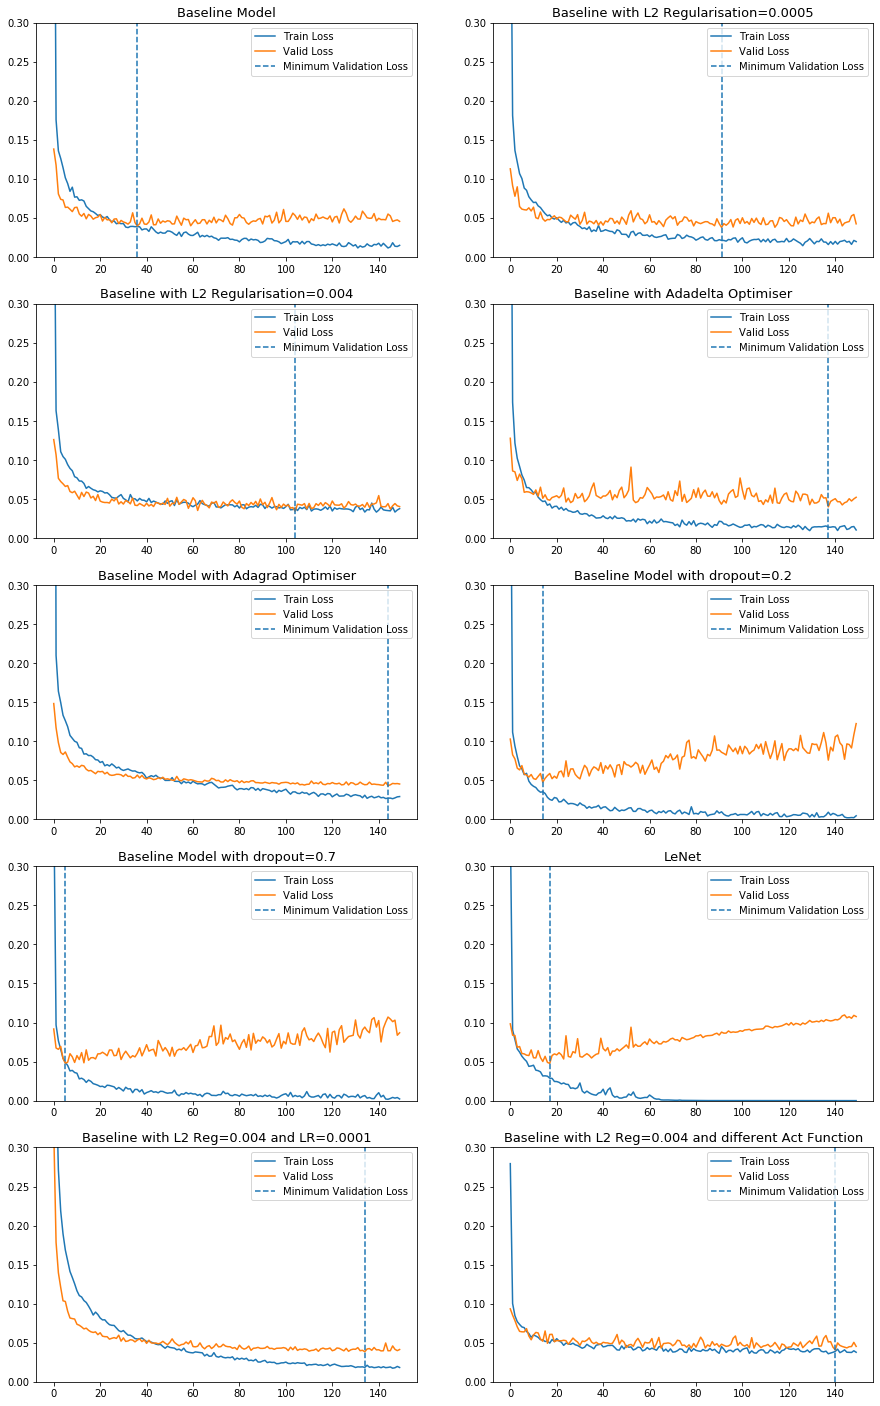

In [ ]:
all_models = [baseline_list, l2reg_1_list, l2_reg2_list, adadmodel_list, adagrad_list,
              dropout_list,dropout2_list,lenet_list,l2regLR_list,diffact_list]
fig, axes = plt.subplots(5, 2, figsize=(15, 25))

idx = 0
for i in range(5):
  for j in range(2):
    axes[i,j].plot(all_models[idx]["trainloss"], label = "Train Loss")
    axes[i,j].plot(all_models[idx]["validloss"], label = "Valid Loss")
    # axes[i,j].plot(all_models[idx]["testloss"], label = "Test Loss")
    axes[i,j].set_ylim(0,0.3)
    axes[i,j].set_title(all_models[idx]["name"],fontsize=13)
    min_valloss = min(all_models[idx]["validloss"])
    min_idx = all_models[idx]["validloss"].index(min_valloss)
    axes[i,j].axvline(x=min_idx, label="Minimum Validation Loss",linestyle='dashed')
    axes[i,j].legend(loc='upper right')
    idx+=1

In [ ]:
variant_table

,Name,Convolution,Classification,Optimiser,L.rate,Regularisation,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc
1,Baseline,Model-1,Model-1,Adam,0.0010,0.0000,0.039141,0.039965,0.045955,99.611612,98.746269,99.020000
2,Baseline with L2 Regularisation=0.0005,Model-1,Model-1,Adam,0.0010,0.0005,0.021428,0.038026,0.043493,99.919920,99.024876,98.900000
3,Baseline with L2 Regularisation=0.004,Model-1,Model-1,Adam,0.0010,0.0040,0.038960,0.034685,0.044707,99.675676,99.024876,98.900000
4,Baseline with Adadelta Optimiser,Model-1,Model-1,Adadelta,1.0000,0.0000,0.014216,0.040264,0.043361,99.987988,98.945274,98.900000
5,Baseline Model with Adagrad Optimiser,Model-1,Model-1,Adagrad,0.0100,0.0000,0.027284,0.043334,0.043241,99.787788,98.626866,98.900000
6,Baseline Model with dropout=0.2,Model-1,Model-1 with dropout rate=0.2,Adam,0.0010,0.0000,0.035430,0.047695,0.043130,99.467467,98.646766,98.900000
7,Baseline Model with dropout=0.7,Model-1,Model-1 with dropout rate=0.7,Adam,0.0010,0.0000,0.048995,0.047878,0.043508,99.291291,98.427861,98.900000
8,LeNet,LeNet,LeNet,Adam,0.0010,0.0000,0.028736,0.047710,0.043538,99.255255,98.686567,98.900000
9,Baseline with L2 Reg=0.004 and LR=0.0001,Model-1,Model-1,Adam,0.0001,0.0040,0.018428,0.038460,0.045133,99.883884,98.865672,98.900000
10,Baseline with L2 Reg=0.004 and different Act F...,Model-1 with Tanh,Model-1 with Tanh,Adam,0.0010,0.0040,0.038971,0.040888,1.613711,99.375375,98.746269,1.613773


The model selected as the best model is Model#3: Baseline with L2 Regularisation=0.004. It has a validation accuracy of 99%. Some variants of this frontrunner model (ex. changing learning rate, changing activation function) proved to be less effective.

# Q3
Was the lowest test loss obtained for model with the lowest validation loss? If not, why do
you think this was the case?

* The model with the lowest test loss is the **Baseline Model with dropout=0.2** model (test loss: 0.043130). 
* The model with the lowest validation loss is the **Baseline with L2 Regularisation=0.004** model (validation loss: 0.034685). 
<br>
* The model with lowest test loss and the model with the lowest validation loss do not match. This can be explained by the high variance of the dataset. If the data has high variance, the model with lowest validation loss may not work well with a test data, since test data is different from validation data.
